
## Progress
* [Import All needed Packages](#Importing-1)
* [Utilities to simplify the code](#Utilities-1)

* [Visualize the training images](#Visualizing)



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name='Importing-1'></a>

### Importing All Nedded Packages

In [ ]:
!pip install medpy
!pip install pydicom
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import time
import random
import pydicom
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from skimage.filters import threshold_yen
from mpl_toolkits.axes_grid import ImageGrid
from skimage.measure import label, regionprops
from medpy.filter.smoothing import anisotropic_diffusion

In [ ]:
path = "/content/drive/MyDrive/GSOC/Dataset/Glioblastoma/UPENN-GBM/UPENN-GBM-00002/11-13-2001-NA-BRAINROUTINE-05064/11.000000-ep2dperf 3cc pre 12bolus-82091"

<a name='Utilities-1'></a>

### Utilities to simplify the code

In [ ]:
def load_dicom_file(filename: str) -> np.ndarray:
    """
    Loads a DICOM file and returns its pixel data as a NumPy array.

    Args:
        filename: A string representing the path to the DICOM file.

    Returns:
        A NumPy array representing the pixel data from the DICOM file.
    """
    # Load the DICOM file
    ds = pydicom.dcmread(filename)

    # Convert the pixel data to a NumPy array
    pixel_array = ds.pixel_array.astype(np.float32)

    # Normalize the pixel values to the range [0, 1]
    pixel_array /= np.max(pixel_array)

    # Return the pixel array
    return pixel_array

In [ ]:
def apply_anisotropic_diffusion_filter(image: np.ndarray) -> np.ndarray:
    """
    Applies an anisotropic diffusion filter to the input image and returns the filtered image.

    Args:
        image: A NumPy array representing the input image.

    Returns:
        A NumPy array representing the filtered image.
    """
    # Apply anisotropic diffusion filter to the image
    filtered_image = anisotropic_diffusion(image, niter=5, kappa=50, gamma=0.1)

    # Return the filtered image
    return filtered_image


In [ ]:
def apply_yen_threshold(image: np.ndarray) -> np.ndarray:
    """
    Applies Yen thresholding to the input image and returns a binary image.

    Args:
        image: A NumPy array representing the input image.

    Returns:
        A binary NumPy array representing the thresholded image.
    """
    # Apply Yen threshold to the filtered image
    threshold_value = threshold_yen(image)
    binary_image = image > threshold_value

    # Return the binary image
    return binary_image


In [ ]:
def apply_labeling(binary_image: np.ndarray) -> np.ndarray:
    """
    Labels connected regions in a binary image and returns the labeled image.

    Args:
        binary_image: A binary NumPy array representing the input image.

    Returns:
        A NumPy array representing the labeled image.
    """
    # Label connected regions in the binary image
    labeled_image = label(binary_image)

    # Return the labeled image
    return labeled_image


In [ ]:
def get_largest_region_properties(labeled_image: np.ndarray) -> Tuple[int, int, int, int]:
    """
    Calculates the properties of the largest connected region in the labeled image
    and returns the bounding box of the region.

    Args:
        labeled_image: A NumPy array representing the labeled image.

    Returns:
        A tuple of integers representing the bounding box of the largest connected region
        in the format (min_row, min_col, max_row, max_col).
    """
    # Calculate properties of connected regions in the labeled image
    regions = regionprops(labeled_image)

    # Find the largest connected region
    largest_region = max(regions, key=lambda r: r.area)

    # Return the bounding box of the largest region
    return largest_region.bbox


In [ ]:
def plot_image_with_bounding_box(image: np.ndarray, bbox: Tuple[int, int, int, int], 
                                 ax: plt.Axes, title: str) -> None:
    """
    Plots the input image and a bounding box on the given axes.

    Args:
        image: A NumPy array representing the input image.
        bbox: A tuple of integers representing the bounding box of the region of interest
            in the format (min_row, min_col, max_row, max_col).
        ax: A matplotlib Axes object to plot the image and bounding box on.
        title: A string representing the title of the plot.

    Returns:
        None
    """
    # Plot the image on the given axes
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

    # Add a rectangle patch to the axes to represent the bounding box
    rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], 
                          linewidth=3, edgecolor='g', facecolor='none')
    ax.add_patch(rect)


<a name='Visualizing'></a>

### Visualize the training image and bounding box

/usr/local/lib/python3.8/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.8/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


Time taken : 2.14 seconds


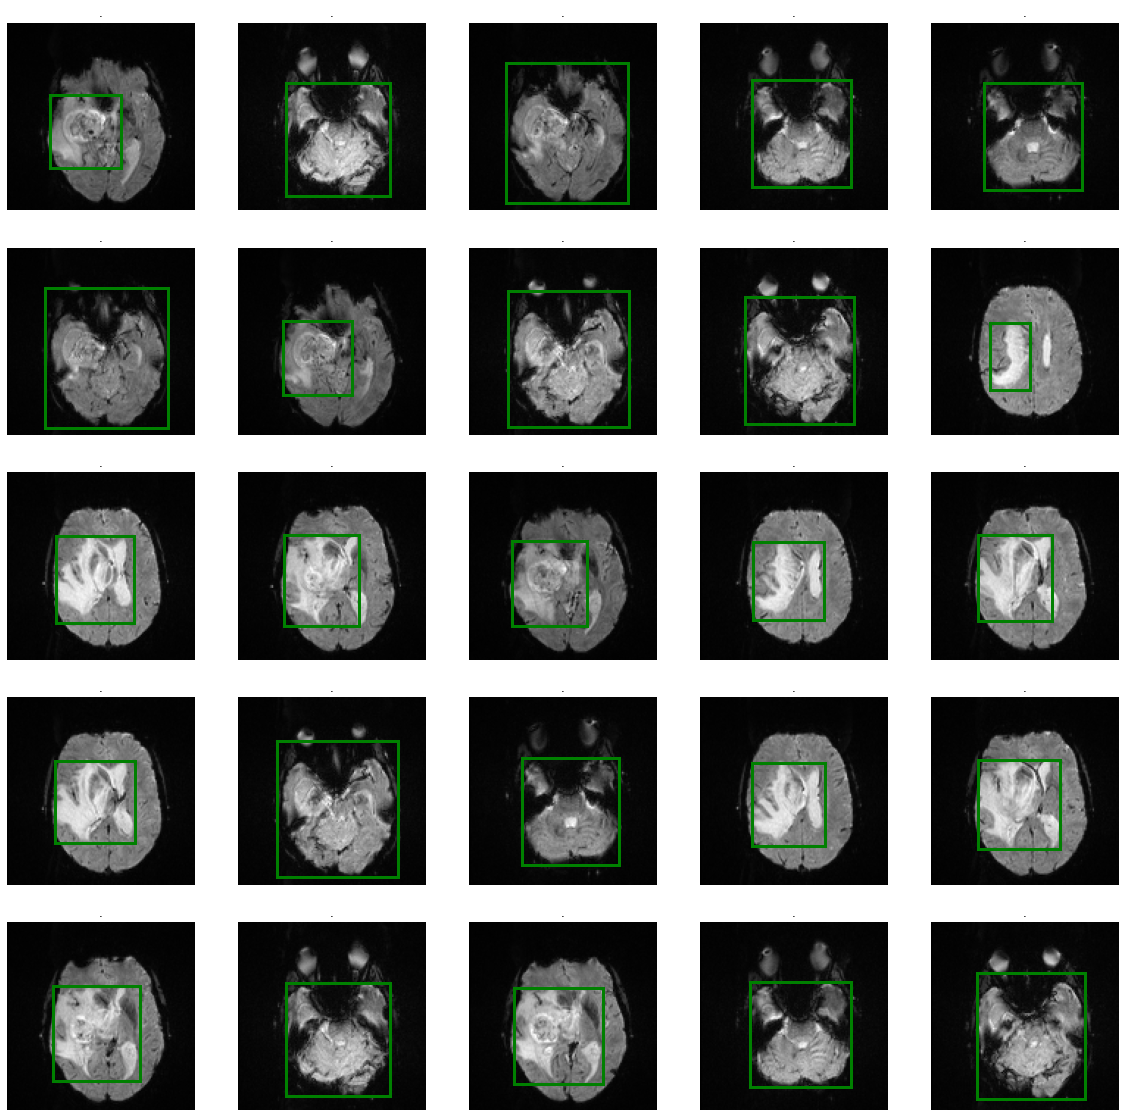

In [ ]:
start_time = time.time()
# Set the path to the directory containing the DICOM images
dir_path = "/content/drive/MyDrive/GSOC/Dataset/Glioblastoma/UPENN-GBM/UPENN-GBM-00002/11-13-2001-NA-BRAINROUTINE-05064/11.000000-ep2dperf 3cc pre 12bolus-82091"

# Get a list of all the DICOM filenames in the directory
filenames = os.listdir(dir_path)
filenames = [f for f in filenames if f.endswith('.dcm')]

# Set the number of rows and columns in the grid
num_rows = 5
num_cols = 5

# Create a new figure with a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop over the filenames and plot the first 20 DICOM images in a subplot
for i, filename in enumerate(filenames[0:25]):
    # Load the DICOM file
    pixel_array = load_dicom_file(os.path.join(dir_path, filename))

    # Apply anisotropic diffusion filter to the image
    filtered_image = apply_anisotropic_diffusion_filter(pixel_array)

    # Apply Yen threshold to the filtered image
    binary_image = apply_yen_threshold(filtered_image)

    # Apply labeling to the binary image
    labeled_image = apply_labeling(binary_image)

    # Get the coordinates of the bounding box for the largest region
    bbox = get_largest_region_properties(labeled_image)

    # Get the row and column index for the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot the image in the subplot with the bounding box
    plot_image_with_bounding_box(pixel_array, bbox, axes[row_idx, col_idx], filename[-4])
elapsed_time = time.time() - start_time

print(f"Time taken : {elapsed_time:0.2f} seconds")
# Show the plot
plt.show()